# Name: Jake Mavrides

### (Optional) Feedback/where I ran into trouble/etc. - 

In this assignment, you will be taking a closer look at the Autoencoder we discussed in lecture.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Dataset originally from Kaggle https://www.kaggle.com/dalpozz/creditcardfraud

Additional Notes and References:
1. https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

In [ ]:
df = pd.read_csv("creditcard.csv")
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('----------------------------')
print('fraud data')
print(frauds.Amount.describe())
print('----------------------------')
print('----------------------------')
print('non-fraud data')
print(normal.Amount.describe())
print('----------------------------')

----------------------------
fraud data
count      56.000000
mean       90.815893
std       310.308450
min         0.000000
25%         1.000000
50%         1.000000
75%         1.025000
max      1809.680000
Name: Amount, dtype: float64
----------------------------
----------------------------
non-fraud data
count    13897.000000
mean        63.773909
std        177.164503
min          0.000000
25%          5.770000
50%         15.900000
75%         52.370000
max       7712.430000
Name: Amount, dtype: float64
----------------------------


In [ ]:
from sklearn.preprocessing import StandardScaler
# disregard the time column, probably won't affect our data predictions
df = df.drop(['Time'], axis=1)
# the type of model we will look at likes values to be between -1 and 1 for normalization purposes
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
# train, test, and split the data with a test size of 25%
X_train, X_test = train_test_split(df, test_size=0.25, random_state=13)
# train on the values that are not fraudulent 
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

![./ad-data/autoencoder.png](attachment:autoencoder.png)

In [ ]:
input_dim = X_train.shape[1]
# build an autoencoder with 2 encode layers and 2 decode layers

# input layer: input_dim nodes
input_layer = Input(shape=(input_dim, ))

# encode layer 1: 14 nodes, tanh activation, ll regularizer with 10e-5
encode_layer = Dense(14, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)

# encode layer 2: 7 nodes, relu activation
encode_layer = Dense(7, activation='relu')(encode_layer)

# decode layer 1: 7 nodes, tanh activation
decode_layer = Dense(7, activation='tanh')(encode_layer)
# decode layer 2: input_dim nodes, relu activation
decode_layer = Dense(input_dim, activation='relu')(decode_layer)

# create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decode_layer)

In [ ]:
# set the number of epochs to 100
num_epochs = 100

# set the batch size to 32
batch_size = 32

# compile the autoencoder using the Nadam optimizer, MSE loss, and set metrics to 'accuracy'
autoencoder.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['accuracy'])

# create snapshots and save it to 'model.h5'
snapshots = ModelCheckpoint(filepath='model.h5', verbose=0, save_best_only=True)

# create a tensorboard and set the log directory to 'logs'
tensorboard = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# train the model
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, validation_data=(X_test, X_test), verbose=1, callbacks=[snapshots, tensorboard]).history

Epoch 1/100
326/326 [==============================] - 3s 4ms/step - loss: 0.7387 - accuracy: 0.7704 - val_loss: 0.8645 - val_accuracy: 0.7455
Epoch 2/100
326/326 [==============================] - 1s 3ms/step - loss: 0.7383 - accuracy: 0.7705 - val_loss: 0.8640 - val_accuracy: 0.7521
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 0.7386 - accuracy: 0.7744 - val_loss: 0.8638 - val_accuracy: 0.7501
Epoch 4/100
326/326 [==============================] - 1s 4ms/step - loss: 0.7384 - accuracy: 0.7732 - val_loss: 0.8629 - val_accuracy: 0.7506
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 0.7379 - accuracy: 0.7747 - val_loss: 0.8630 - val_accuracy: 0.7452
Epoch 6/100
326/326 [==============================] - 1s 3ms/step - loss: 0.7380 - accuracy: 0.7726 - val_loss: 0.8624 - val_accuracy: 0.7498
Epoch 7/100
326/326 [==============================] - 1s 4ms/step - loss: 0.7374 - accuracy: 0.7699 - val_loss: 0.8625 - val_accuracy: 0.7463

In [ ]:
# load the current state of the model
autoencoder = load_model('/content/model.h5')
# make predictions on the test data
predictions = autoencoder.predict(X_test)
# compute the mean squared error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
# save this into a dataframe for later comparison
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
fraud_error_df = error_df[error_df['true_class'] == 1]

110/110 [==============================] - 0s 2ms/step


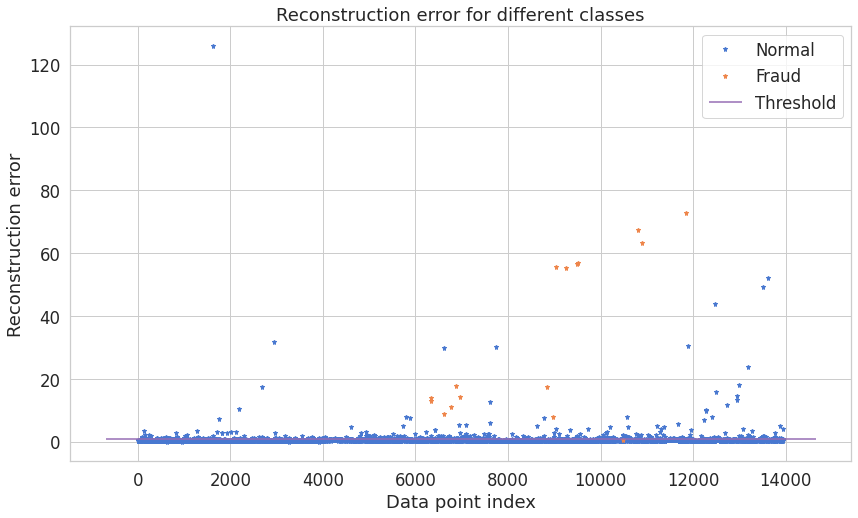

In [ ]:
# visualize the results in the form of a scatterplot and pinpoint the outliers
# play with the parameters of the plot to create a different 'look' than the one in lecture :)  
threshold = 1
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    # change these parameters in ax.plot(...)
    ax.plot(group.index, group.reconstruction_error, marker='*', ms=5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="m", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

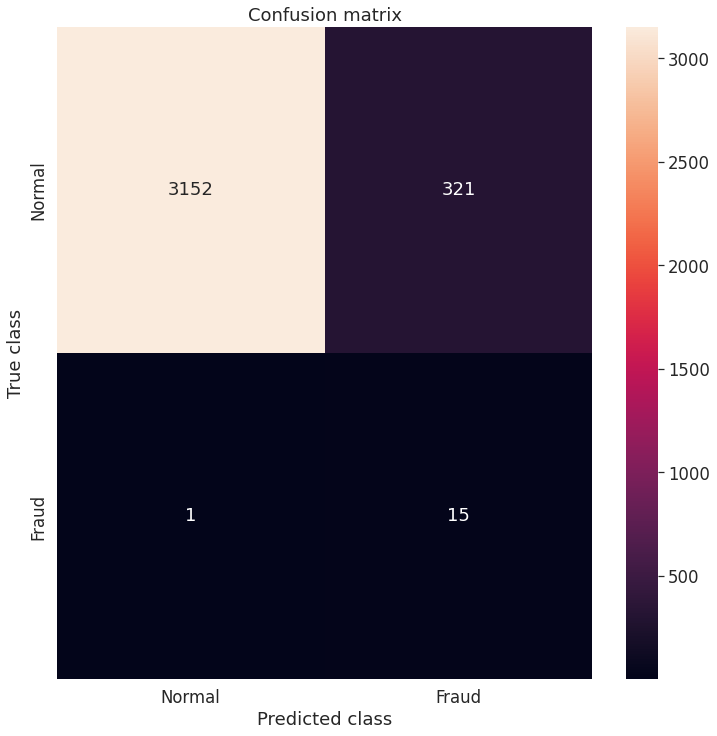

In [ ]:
# visualize the results in relation to the original data
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### Q1: Why is a neural network a good option for anomaly detection? 
Neural networks are a good choice for dealing with large datasets, and are especially good at detecting outliers in data, even if the reason behind the outlier is unknown (due to the learning's nature to create and detect connections within data that we could never identify manually).

#### Q2: Does increasing the number of layers speed up training time?
No, if anything, more layers increases the time to train.

#### Q3: Does significantly increasing the number of epochs have a 'large' affect on the accuracy in this example? Justify your reponse.
It depends on the definition of 'large' and 'significantly increasing'. However, I increased the number of epochs from 10 to 100 and recreated the heatmap. The number of 'frauds predicted as normal' and 'frauds as fraud' was unchanged. The number of 'normal predicted as fraud' increased by a little over 2%, which I would not consider a 'large' affect.

#### Q4: Name three optimizers other than Nadam and Adam that can be passed into `Model.compile()`
SGD (Stochastic Gradient Descent), AdamW, and AdaDelta.

#### Q5: Does increasing the number of batch size always improve the prediction accuracy? Why or why not?
No, using a batch size that is too large could lead to overfitting of your data and its trends. 

#### Q6: Play with the threshold. What's the best number you think for our model? Justify your answer.
It depends on if we define our optimal threshold to be as close to an accurate predictor as possible, or to minimize non-informative predictions. Playing around with the values, it appears a threshold of around 7 is optimal (for our data), as it increases the number of 'normals detected as normal' without leading to any loss of incorrect predictions. Because we are dealing with credit card fraud, however, a 'better safe than sorry' approach is more practical. Because of this I believe a more generous threshold is optimal if we are applying our model to unknown data/in the real world. ex: a lower threshold such as 1 so as to increase our 'safety net' of detection, as a false-fraudulent detection is not a big deal, but a false-normal detection is.